In [1]:
import tensorflow as tf
import os
import numpy as np
from glob import glob as glb
from tqdm import *
import h5py
import matplotlib.pyplot as plt

/Users/ichang-geon/.pyenv/versions/2.7.14/envs/flow/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/Users/ichang-geon/.pyenv/versions/2.7.14/envs/flow/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/Users/ichang-geon/.pyenv/versions/2.7.14/envs/flow/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p


In [2]:
def load_flow(filename, shape):
  stream_flow = h5py.File(filename, 'r')
  flow_state_vel = np.array(stream_flow['Velocity_0'][:])
  flow_state_vel = flow_state_vel.reshape([shape[0], shape[1]+128, 3])[0:shape[0],0:shape[1],0:2]
  stream_flow.close()
  return flow_state_vel

def load_boundary(filename, shape):
  stream_boundary = h5py.File(filename, 'r')
  boundary_cond = np.array(stream_boundary['Gamma'][:])
  boundary_cond = boundary_cond.reshape([shape[0], shape[1]+128, 1])[0:shape[0],0:shape[1],:]
  stream_boundary.close()
  return boundary_cond

In [3]:
tf.reset_default_graph()

In [4]:
n_batch = 1
learning_rate = 0.0001
keep_prob = 1

X = tf.placeholder(tf.float32 , [None,128,256,1], name="X")

#Conv1
W1 = tf.Variable(tf.random_normal([16, 16, 1, 128], stddev=0.01))
L1 = tf.nn.conv2d(X, W1, strides=[1, 8, 16, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.dropout(L1, keep_prob)

#Cov2
W2 = tf.Variable(tf.random_normal([4,4,128,512], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 4, 4, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.dropout(L2, keep_prob)

L2_flat = tf.reshape(L2,[-1,4*4*512])

W3 = tf.get_variable("W", shape=[512 * 4 * 4, 1024],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([1024]))
L3 = tf.nn.relu(tf.matmul(L2_flat, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

# L3 = tf.divide(L3,y)
S1, S2 = tf.split(L3, [512, 512], 1)

S1= tf.reshape(S1,[n_batch,1,1,512])
S2= tf.reshape(S2,[n_batch,1,1,512])

# deconv1
W4_1 = tf.Variable(tf.random_normal([8,8,512,512], stddev=0.01))
L4_1 = tf.nn.conv2d_transpose(S1,W4_1,output_shape=[n_batch,8,8,512],strides=[1,8, 8, 1], padding='SAME')
L4_1 = tf.nn.relu(L4_1)
L4_1 = tf.nn.dropout(L4_1, keep_prob)

W4_2 = tf.Variable(tf.random_normal([8,8,512,512], stddev=0.01))
L4_2 = tf.nn.conv2d_transpose(S2,W4_2,output_shape=[n_batch,8,8,512],strides=[1,8, 8, 1], padding='SAME')
L4_2 = tf.nn.relu(L4_2)
L4_2 = tf.nn.dropout(L4_2, keep_prob)

## deconv2
W5_1 = tf.Variable(tf.random_normal([4,8,256,512], stddev=0.01))
L5_1 = tf.nn.conv2d_transpose(L4_1,W5_1,output_shape=[n_batch,32,64,256],strides=[1, 4, 8, 1], padding='SAME')
L5_1 = tf.nn.relu(L5_1)
L5_1 = tf.nn.dropout(L5_1, keep_prob)

W5_2 = tf.Variable(tf.random_normal([4,8,256,512], stddev=0.01))
L5_2 = tf.nn.conv2d_transpose(L4_2,W5_2,output_shape=[n_batch,32,64,256],strides=[1,4, 8, 1], padding='SAME')
L5_2 = tf.nn.relu(L5_2)
L5_2 = tf.nn.dropout(L5_2, keep_prob)

# deconv3
W6_1 = tf.Variable(tf.random_normal([2,2,32,256], stddev=0.01))
L6_1 = tf.nn.conv2d_transpose(L5_1,W6_1,output_shape=[n_batch,64,128,32],strides=[1,2, 2, 1], padding='SAME')
L6_1 = tf.nn.relu(L6_1)
L6_1 = tf.nn.dropout(L6_1, keep_prob)

W6_2 = tf.Variable(tf.random_normal([2,2,32,256], stddev=0.01))
L6_2 = tf.nn.conv2d_transpose(L5_2,W6_2,output_shape=[n_batch,64,128,32],strides=[1,2, 2, 1], padding='SAME')
L6_2 = tf.nn.relu(L6_2)
L6_2 = tf.nn.dropout(L6_2, keep_prob)

# deconv4
W7_1 = tf.Variable(tf.random_normal([2,2,1,32], stddev=0.01))
L7_1 = tf.nn.conv2d_transpose(L6_1,W7_1,output_shape=[n_batch,128,256,1],strides=[1,2,2, 1], padding='SAME')
L7_1 = tf.nn.dropout(L7_1, keep_prob)

W7_2 = tf.Variable(tf.random_normal([2,2,1,32], stddev=0.01))
L7_2 = tf.nn.conv2d_transpose(L6_2,W7_2,output_shape=[n_batch,128,256,1],strides=[1,2, 2, 1], padding='SAME')
L7_2 = tf.nn.dropout(L7_2, keep_prob)

sflow_p = tf.stack([L7_1 , L7_2] , axis=3)
sflow_p = tf.reshape(sflow_p , [n_batch,128,256,2])

In [5]:
saver = tf.train.Saver()

In [6]:
sess = tf.Session()
# Restore variables from disk.
saver.restore(sess, "./model_save/model.ckpt")

INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt


In [7]:
#test
shape = [128,256]
flow_name = './fluid_flow_0002.h5'
boundary_np = load_boundary(flow_name, shape).reshape([1, shape[0], shape[1], 1])
sflow_true = load_flow(flow_name, shape)

In [8]:
# calc logits 
sflow_generated = sess.run(sflow_p,feed_dict={X: boundary_np})[0]
print(sflow_generated.shape)

(128, 256, 2)


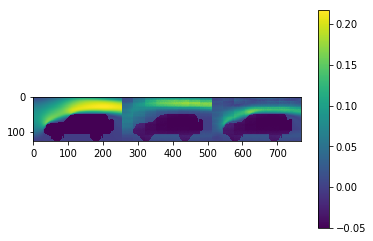

In [9]:

# convert to display 
sflow_plot = np.concatenate([sflow_true, sflow_generated, sflow_true - sflow_generated], axis=1) 
boundary_concat = np.concatenate(3*[boundary_np], axis=2) 
sflow_plot = np.sqrt(np.square(sflow_plot[:,:,0]) + np.square(sflow_plot[:,:,1])) - .05 *boundary_concat[0,:,:,0]

# display it
plt.imshow(sflow_plot)
plt.colorbar()
plt.show()
